# Damage Function Estimation

## Helper function definitions

In [201]:
import numpy as np
import pandas as pd
from pathlib import Path


# Declare a function which will grow back a series based on another series
def grow_back_series(series_to_grow: pd.Series, substrate: pd.Series):

    # Trim down the series so they correspond to the same years
    substrate = substrate[series_to_grow.index]
    

    if(len(series_to_grow) != len(substrate)):
        raise ValueError('Must be the same length.')

    index = series_to_grow.index

    y = pd.Series(series_to_grow.copy().values)
    x = pd.Series(substrate.copy().values)

    first_non_nan = y.isnull().idxmin()
    changes = x[:first_non_nan+1].pct_change()
    while first_non_nan > 0:
        y[first_non_nan-1] = y[first_non_nan]/(changes[first_non_nan]+1)
        first_non_nan -= 1

    y.index = index

    return y

def grow_forward_series(series_to_grow: pd.Series, substrate: pd.Series):

    # Trim down the series so they correspond to the same years
    substrate = substrate[series_to_grow.index]

    if(len(series_to_grow) != len(substrate)):
        raise ValueError(
            'Series to grow and substrate must be the same length')

    index = series_to_grow.index

    y = pd.Series(series_to_grow.copy().values)
    x = pd.Series(substrate.copy().values)

    # This should start from the first non nan value after any values
    # that are already set.
    first_non_nan = y.isnull().idxmax()
    # Check that there are no values after the first non nan
    for i in range(first_non_nan, len(y)):
        if(np.isnan(y[i]) == False):
            first_non_nan = i
            break

    changes = x[first_non_nan-1:].pct_change()

    while first_non_nan < len(y):

        if (~np.isnan(y[first_non_nan])):
            y[first_non_nan] = y[first_non_nan]
        else:
            y[first_non_nan] = y[first_non_nan-1] * \
                (1 + (changes[first_non_nan]))

        first_non_nan += 1

    y.index = index

    return y

In [202]:
def grow_precp_forward(hist, forecast):
    output_series = []
    y_index = forecast.index

    for i, t in enumerate(forecast.index):
        changes = forecast.pct_change().fillna(1)

        growth_rate = changes[t]
        
        if i == 0:
            output_series.append(hist[t] * growth_rate)
        else:
            output_series.append(output_series[i-1] * (1 + growth_rate))

    output = pd.Series(output_series, index=y_index)

    return output

## Process raw climate data inputs

In [203]:

# -----------------------------------------------------------------------
# This cell processes the climate data
# for each country and creates an output dataframe
# of variables that will be used in the calculation of damage functions
# -----------------------------------------------------------------------

# Set the base path programmatically so that 
# the code will run on any machine without changing variables
base_path = Path('../../..').parent.absolute()

# Dataframe used for matching countries together by name, code, iso etc. 
country_map = pd.read_csv('../../Data/resources/countries.csv', encoding="latin-1").set_index('alpha-3')

# List of countries in sample
countries = ['DZA','AGO','BEN','BWA','BFA','BDI','CMR','COG', 'CIV','COD', 'CAF','TCD','COM','DJI','ERI','ETH', 'EGY', 'GAB','GHA','GIN','GNB','GNQ','GMB','KEN','LSO','LBR','LBY','MDG','MLI','MWI','MRT','MUS','MAR','MOZ','NAM','NER','NGA','RWA','STP','SEN','SLE','SOM','ZAF','SSD','SDN','SWZ','TGO','TUN','TZA','UGA', 'ZMB','ZWE']

# Initialise the output dataframe, which will include all of the 
# climate data
climate_full = pd.DataFrame()

# The list of climate variables tas = Mean Temperature, pr = precipitation
variables = ['tas', 'pr']

# The climate pathways in study
pathways = ['ssp119', 'ssp245', 'ssp370', 'ssp585']


# Loop over each country and variable
# to create the necessary variables for the 
# calculations
for country in countries:
    for variable in variables:
        # Read in the climate data file for the 
        # given country and variable
        historical = pd.read_csv(f'{base_path}/Data/raw/climate_data/historical/{variable}/{variable}_timeseries_annual_cru_1901-2020_{country}.csv', header=1)

        # The climate data is at a regional level, where the first column
        # is for the total country. This line retains only the country level series
        historical = historical.iloc[:, 0:2]

        # Set the column names to be 'year' and the name of the climate variable.
        # Then, set the the index to be the year, and turn this into a Pandas DateTime Period type
        historical.columns = ['year', variable]
        historical.set_index('year', inplace=True)
        historical.index = pd.PeriodIndex(historical.index, freq='A')

        # Cut of the historical data in 2015, this avoids a series
        # break in 2020 which affects the output data in weird ways.
        historical = historical.loc[:'2021', :]

        # Get the latest year of data, should be 2015 every time
        latest_year = historical.index.max()

        # Loop over the pathways to create special vars
        for pathway in pathways:
            # Load data
            df = pd.read_csv(f'{base_path}/Data/raw/climate_data/forecast/{pathway}/{variable}/{variable}_timeseries_annual_cmip6_{pathway}_ensemble_2015-2100_median{country}.csv',header=1)
            
            # Same as above
            df = df.iloc[:, 0:2]
            df.columns = ['year', variable]
            df.set_index('year', inplace=True)
            df.index = pd.PeriodIndex(df.index, freq='A')

            # Get forecast data past the historical end point.
            df = df.loc['2020':, :]

            # Merge historical into pathway
            series = pd.concat([historical[variable], df[variable]['2021':]], axis=0)


            if (variable == 'pr'):
                new_forecast_series = grow_precp_forward(historical[variable], df[variable])
                series = pd.concat([historical[variable], new_forecast_series['2021':]], axis=0)

            series.name = f'{country}_{pathway}_{variable}'

            pathway_df = pd.DataFrame(series)


            moving_average_period = 25

            # if (variable == 'pr'):
            #     moving_average_period = 10

            # Create a 15 period moving average for the climate variable.
            pathway_df[f'{country}_{pathway}_{variable}_ma{str(moving_average_period)}'] = pathway_df[f'{country}_{pathway}_{variable}'].rolling(window=moving_average_period).mean()
        
            # Substract the moving average from the forecast series to get a series of
            # devations from average. This will be the baseline for the annual yield impacts.
            pathway_df[f'{country}_{pathway}_{variable}star'] = pathway_df[f'{country}_{pathway}_{variable}'] - pathway_df[f'{country}_{pathway}_{variable}_ma{str(moving_average_period)}']

            # Create a series for positive and negative shocks
            # (i.e) xxxp will be 0s unless positive shock, and xxxn will be 0s unless negative shocks
            # pathway_df[f'{country}_{pathway}_{variable}starp'] = pathway_df[f'{country}_{pathway}_{variable}star'].apply(lambda x: x if x > 0 else 0)
            # pathway_df[f'{country}_{pathway}_{variable}starn'] = pathway_df[f'{country}_{pathway}_{variable}star'].apply(lambda x: x if x < 0 else 0)

            # Add these output variables to on dataframe which 
            # will contain data for all countries and variables
            climate_full = pd.concat([climate_full, pathway_df], axis=1)

    
climate_full.to_excel(f'{base_path}/checks/climate_full.xlsx')

climate_full_parquet = climate_full.copy()
climate_full_parquet.index = climate_full_parquet.index.astype(int)
climate_full_parquet.to_parquet(f'{base_path}/Data/processed/climate_full.parquet')

climate_full.head()

,DZA_ssp119_tas,DZA_ssp119_tas_ma25,DZA_ssp119_tasstar,DZA_ssp245_tas,DZA_ssp245_tas_ma25,DZA_ssp245_tasstar,DZA_ssp370_tas,DZA_ssp370_tas_ma25,DZA_ssp370_tasstar,DZA_ssp585_tas,...,ZWE_ssp119_prstar,ZWE_ssp245_pr,ZWE_ssp245_pr_ma25,ZWE_ssp245_prstar,ZWE_ssp370_pr,ZWE_ssp370_pr_ma25,ZWE_ssp370_prstar,ZWE_ssp585_pr,ZWE_ssp585_pr_ma25,ZWE_ssp585_prstar
year,,,,,,,,,,,,,,,,,,,,,
1901,22.58,NaN,NaN,22.58,NaN,NaN,22.58,NaN,NaN,22.58,...,NaN,836.85,NaN,NaN,836.85,NaN,NaN,836.85,NaN,NaN
1902,22.58,NaN,NaN,22.58,NaN,NaN,22.58,NaN,NaN,22.58,...,NaN,655.70,NaN,NaN,655.70,NaN,NaN,655.70,NaN,NaN
1903,22.48,NaN,NaN,22.48,NaN,NaN,22.48,NaN,NaN,22.48,...,NaN,549.50,NaN,NaN,549.50,NaN,NaN,549.50,NaN,NaN
1904,22.65,NaN,NaN,22.65,NaN,NaN,22.65,NaN,NaN,22.65,...,NaN,694.97,NaN,NaN,694.97,NaN,NaN,694.97,NaN,NaN
1905,22.43,NaN,NaN,22.43,NaN,NaN,22.43,NaN,NaN,22.43,...,NaN,508.35,NaN,NaN,508.35,NaN,NaN,508.35,NaN,NaN


## Yield Data Processing

In [204]:
yield_data = pd.read_parquet(
    '../../Data/processed/africa_crop_yield_data.parquet')

yield_countries = yield_data.columns.get_level_values(0).unique()

# Remove Ethiopia from the list of countries
yield_countries = yield_countries.drop('Ethiopia')

for yield_country in yield_countries:
    # Get the yield data for the given country
    yield_country_df = yield_data.iloc[:, yield_data.columns.get_level_values(0) == yield_country].copy()

    # Interpolate missing values
    yield_country_df = yield_country_df.interpolate(method='linear', axis=0)

    # Grow back series based on average growth of all
    mean_growth = yield_country_df.mean(axis=1)

    for col in yield_country_df:
        series = yield_country_df[col]

        grown_back_series = grow_back_series(series, mean_growth)
        grown_back_series.name = series.name

        yield_country_df[col] = grown_back_series
        yield_data[col] = grown_back_series

yield_data = yield_data.dropna(axis=1, how='any')

yield_data.head()

Country             Algeria                                              \
Crop    Almonds, with shell   Apples Apricots Artichokes        Bananas   
Year                                                                      
1961                 4511.0  45294.0  30286.0    76000.0  184824.784352   
1962                 4511.0  45161.0  30000.0    74000.0  194067.054758   
1963                 4511.0  46429.0  30000.0    80000.0  191269.465529   
1964                 4507.0  46078.0  35476.0    61947.0  174459.991857   
1965                 4493.0  45348.0  34273.0    77193.0  168368.860944   

Country                                                                \
Crop     Barley Beans, dry Beans, green Broad beans, horse beans, dry   
Year                                                                    
1961     2232.0     7959.0      50000.0                        4079.0   
1962     8354.0     8333.0      49615.0                        2462.0   
1963     7431.0     7647.0      54167.0                        2615.0   
1964     4933.0     7402.0      40212.0                        9211.0   
1965     6010.0     6147.0      32726.0                        6734.0   

Country                               ...       Zimbabwe                 \
Crop    Cabbages and other brassicas  ... Sunflower seed Sweet potatoes   
Year                                  ...                                 
1961                    25473.948994  ...         7144.0        47892.0   
1962                    26747.788570  ...         5657.0        47436.0   
1963                    26362.203674  ...         5740.0        47753.0   
1964                    24045.394938  ...         5133.0        31020.0   
1965                    23205.869229  ...         5094.0        27778.0   

Country                                                       \
Crop    Tangerines, mandarins, clementines, satsumas     Tea   
Year                                                           
1961                                         56250.0  9002.0   
1962                                         56250.0  9673.0   
1963                                         57500.0  6687.0   
1964                                         56471.0  6465.0   
1965                                         56471.0  6208.0   

Country                                                                      \
Crop    Tobacco, unmanufactured Tomatoes      Vanilla Vegetables, fresh nes   
Year                                                                          
1961                    11847.0  72222.0  1914.190384               64889.0   
1962                    11815.0  71579.0  2089.565069               64879.0   
1963                     9250.0  73684.0  1866.250728               64874.0   
1964                    14099.0  70000.0  2221.400435               64892.0   
1965                    13029.0  75000.0  2286.536352               64909.0   

Country                                      
Crop    Vegetables, leguminous nes    Wheat  
Year                                         
1961                  48512.075233  14673.0  
1962                  52956.664442  15895.0  
1963                  47297.121789  19530.0  
1964                  56297.819662  26896.0  
1965                  57948.584674  23533.0  

[5 rows x 1982 columns]

In [205]:
# -----------------------------------------------------------------------
# This cell grows the crop yield data for each country
# -----------------------------------------------------------------------

def grow_forward_series(series_to_grow: pd.Series):

    # Make sure that the series index is a period
    series_to_grow.index = pd.to_datetime(series_to_grow.index, format="%Y").to_period('A')

    # Get average of the previous 20 years of growth rates
    # avg_growth = (series_to_grow['2019']/series_to_grow['1961'])**(1/58)-1 # uses long run CAGR
    avg_growth = series_to_grow.loc['2000':'2019'].pct_change().mean()

    # last year
    last_year = series_to_grow.index.max()
    target_year = 2100

    dates = pd.date_range(start=pd.to_datetime(last_year+1, format="%Y"), end=pd.to_datetime(target_year, format="%Y"), freq='A').to_period('A')

    grow_into = pd.Series(np.nan, index=dates)

    full_series = pd.concat([series_to_grow, grow_into], axis=0)

    # Loop over every year and value in the series
    for index, value in full_series.iteritems():
        # If the value is nan, we need to forecast it,
        # so we do that here
        if (np.isnan(value)):
            forecasted_value = full_series.loc[index-1] * (1 + avg_growth)
            full_series[index] = forecasted_value

    return full_series

# Full series of grown forward yields
yield_full_df = pd.DataFrame(columns=yield_data.columns)


# # Loop over the crop yields and forecast out to 2100
for yield_country in yield_countries:

    yield_country_df = yield_data.iloc[:, yield_data.columns.get_level_values(0) == yield_country].copy()

    for crop in yield_country_df.columns.get_level_values(1):
        
        # get the crop yield as a series
        crop_series = yield_country_df.loc[:, (yield_country, crop)]

        series = yield_country_df.loc[:, (yield_country, crop)]
        grown_series = grow_forward_series(series)

        

        yield_full_df.loc[:, (yield_country, crop)] = grown_series



## Apply the damage functions

In [206]:
# -----------------------------------------------------------------------
# Apply the damage functions
# -----------------------------------------------------------------------
from tqdm import tqdm
# read in coeffs

coeffs = pd.read_parquet('./damage_coefficients.parquet')


countries = yield_full_df.columns.get_level_values(0).to_series().unique()

yield_full_df = yield_full_df.loc['2022':, :]
climate_full = climate_full.loc['2022':, :]


climate_damage_full = pd.DataFrame()
damage_pct = pd.DataFrame()

pathways = ['ssp119', 'ssp245', 'ssp370', 'ssp585']

for country in tqdm(countries):

        country_code = country_map[country_map.name == country].index[0]

        crops = yield_full_df.loc[:, yield_full_df.columns.get_level_values(
            0) == country].columns.get_level_values(1)

        for crop in tqdm(crops, leave=False):

            # Get damange coefficents for crop
            try:
                dmg_coeffs = coeffs.loc[(country, crop), :]
            except:
                continue

            for pathway in pathways:
        
                temp = climate_full.loc[:, f'{country_code}_{pathway}_tas']
                prec = climate_full.loc[:, f'{country_code}_{pathway}_pr']

                tempstar = climate_full.loc[:, f'{country_code}_{pathway}_tasstar']
                precstar = climate_full.loc[:, f'{country_code}_{pathway}_prstar']

                # Estimate damage on crop
                def damage(x):

                    temp_yr = temp[x.name]
                    prec_yr = prec[x.name]
                    tstar_yr = tempstar[x.name]
                    pstar_yr = precstar[x.name]

                    # tas	pr	tasstar	tasstar2	prstar
                    return dmg_coeffs['estimated_effects'] + (tstar_yr * dmg_coeffs['tasstar']) + (tstar_yr ** 2 * dmg_coeffs['tasstar2']) + (pstar_yr * dmg_coeffs['prstar']) + (pstar_yr ** 2 * dmg_coeffs['prstar2'])

                series = yield_full_df.loc[:, (country, crop)]
              
                baseline_change = series.pct_change()
                growth= series.to_frame().apply(damage, axis=1)
    
                growth.name = (country, crop, pathway)

                # Add the damage to the climate data
                climate_damage_full = pd.concat([climate_damage_full, growth], axis=1)
            

                climate_damage_full = climate_damage_full.copy()

climate_damage_full.columns = pd.MultiIndex.from_tuples(climate_damage_full.columns)

100%|██████████| 48/48 [00:44<00:00,  1.09it/s]


In [207]:
def grow_forward(start_value: float, growth_series: pd.Series):

    output = []

    for value in growth_series:
        output.append(start_value * (1 + value))
        start_value = output[-1]

    return output

In [208]:
output_df = pd.DataFrame(columns=climate_damage_full.columns, index=climate_damage_full.index)

for col in climate_damage_full:
    start_value = yield_full_df.loc['2022', (col[0], col[1])]
    forecast = grow_forward(start_value, climate_damage_full[col])
    
    output_df.loc[:, col] = forecast

    
output_df 

Algeria                                              \
     Almonds, with shell                                               
                  ssp119         ssp245         ssp370        ssp585   
2022        20823.388877   20840.327047   20701.884023  2.075190e+04   
2023        21741.014374   21661.867729   21652.175307  2.162279e+04   
2024        22634.772836   22721.095205   22485.087563  2.250258e+04   
2025        23881.990943   23775.162992   23401.095084  2.341406e+04   
2026        25094.677897   24881.842387   24509.465500  2.458840e+04   
...                  ...            ...            ...           ...   
2095       376499.039794  382782.272703  579875.771510  1.220879e+06   
2096       392476.941476  397505.069086  605038.367847  1.304973e+06   
2097       408701.625701  412508.978989  638543.022731  1.405290e+06   
2098       430505.524097  427946.316370  672178.074822  1.494422e+06   
2099       452564.980749  443924.887389  705177.970513  1.580337e+06   

                                                                             \
            Apples                                                 Apricots   
            ssp119        ssp245        ssp370         ssp585        ssp119   
2022  1.975949e+05  1.973790e+05  1.987321e+05  198233.887567  7.347629e+04   
2023  2.035077e+05  2.040992e+05  2.043306e+05  204535.049172  7.656809e+04   
2024  2.101280e+05  2.092191e+05  2.114605e+05  211272.573878  7.992315e+04   
2025  2.140842e+05  2.149874e+05  2.184297e+05  218263.233793  8.279946e+04   
2026  2.190559e+05  2.208789e+05  2.242470e+05  223462.749207  8.594185e+04   
...            ...           ...           ...            ...           ...   
2095  1.801181e+06  2.057504e+06  1.410451e+06  641936.756057  3.111140e+06   
2096  1.849145e+06  2.128798e+06  1.453422e+06  644893.401537  3.294468e+06   
2097  1.901438e+06  2.201449e+06  1.480502e+06  642343.762146  3.484439e+06   
2098  1.924765e+06  2.278267e+06  1.512228e+06  648905.370417  3.711371e+06   
2099  1.954069e+06  2.358074e+06  1.550237e+06  659586.150655  3.947383e+06   

                    ...              Zimbabwe                \
                    ... Vegetables, fresh nes                 
            ssp245  ...                ssp370        ssp585   
2022  7.336750e+04  ...          71043.279437  71136.700258   
2023  7.672096e+04  ...          71265.289800  71337.651252   
2024  7.969272e+04  ...          71585.551207  71595.249128   
2025  8.289689e+04  ...          71891.680661  71733.125392   
2026  8.621077e+04  ...          72072.926811  71976.743696   
...            ...  ...                   ...           ...   
2095  1.841880e+06  ...          81320.410337  68779.299591   
2096  1.928417e+06  ...          81666.870164  68725.498231   
2097  2.028286e+06  ...          81767.635450  68655.466173   
2098  2.130288e+06  ...          81687.555302  68214.135436   
2099  2.237118e+06  ...          81728.735708  68065.762106   

                                                                           \
     Vegetables, leguminous nes                                             
                         ssp119        ssp245        ssp370        ssp585   
2022               50275.620649  49893.496763  49594.497082  49815.194224   
2023               50093.639128  49508.265208  49272.396510  49582.752269   
2024               50063.683763  48902.174316  49223.056296  49356.629594   
2025               49905.779529  49016.430776  49126.865938  48932.610483   
2026               49525.244784  48756.596527  48731.391811  48663.962932   
...                         ...           ...           ...           ...   
2095               65155.284579  41214.283559  24730.572745  13931.783871   
2096               65541.125975  41449.296095  24675.380027  13673.979726   
2097               65783.007455  41692.338273  24366.105847  13397.338159   
2098               66034.341920  41813.213587  23885.158719  12938.528355   
2099             

In [209]:
climate_damage_full_pct = pd.DataFrame(columns=climate_damage_full.columns, index=climate_damage_full.index)

for column in output_df.columns:
    # Get each pathway as a pct of SSP245
    series = output_df.loc[:, column]
    col_245 = output_df.loc[:, (column[0], column[1], 'ssp245')]
    pct_damage = (series / col_245) - 1
    climate_damage_full_pct.loc[:, column] = pct_damage

In [210]:
climate_damage_full_pct

Algeria                                              \
     Almonds, with shell                               Apples          
                  ssp119 ssp245    ssp370    ssp585    ssp119 ssp245   
2022           -0.000813    0.0 -0.006643 -0.004243  0.001094    0.0   
2023            0.003654    0.0 -0.000447 -0.001804 -0.002898    0.0   
2024           -0.003799    0.0 -0.010387 -0.009617  0.004344    0.0   
2025            0.004493    0.0 -0.015734 -0.015188 -0.004201    0.0   
2026            0.008554    0.0 -0.014966 -0.011794 -0.008253    0.0   
...                  ...    ...       ...       ...       ...    ...   
2095           -0.016415    0.0  0.514897  2.189488 -0.124580    0.0   
2096           -0.012649    0.0  0.522090  2.282909 -0.131367    0.0   
2097           -0.009230    0.0  0.547949  2.406688 -0.136279    0.0   
2098            0.005980    0.0  0.570707  2.492077 -0.155163    0.0   
2099            0.019463    0.0  0.588507  2.559920 -0.171328    0.0   

                                           ...              Zimbabwe  \
                          Apricots         ... Vegetables, fresh nes   
        ssp370    ssp585    ssp119 ssp245  ...                ssp370   
2022  0.006855  0.004331  0.001483    0.0  ...             -0.001652   
2023  0.001134  0.002136 -0.001993    0.0  ...             -0.001311   
2024  0.010713  0.009815  0.002891    0.0  ...              0.001726   
2025  0.016012  0.015238 -0.001175    0.0  ...              0.000735   
2026  0.015249  0.011698 -0.003119    0.0  ...             -0.000197   
...        ...       ...       ...    ...  ...                   ...   
2095 -0.314485 -0.688002  0.689112    0.0  ...             -0.135354   
2096 -0.317257 -0.697062  0.708379    0.0  ...             -0.136371   
2097 -0.327488 -0.708218  0.717923    0.0  ...             -0.139905   
2098 -0.336238 -0.715176  0.742192    0.0  ...             -0.145213   
2099 -0.342583 -0.720286  0.764495    0.0  ...             -0.149395   

                                                                      \
               Vegetables, leguminous nes                              
        ssp585                     ssp119 ssp245    ssp370    ssp585   
2022 -0.000339                   0.007659    0.0 -0.005993 -0.001569   
2023 -0.000297                   0.011824    0.0 -0.004764  0.001505   
2024  0.001862                   0.023752    0.0  0.006562  0.009293   
2025 -0.001472                   0.018144    0.0  0.002253 -0.001710   
2026 -0.001531                   0.015765    0.0 -0.000517 -0.001900   
...        ...                        ...    ...       ...       ...   
2095 -0.268698                   0.580891    0.0 -0.399951 -0.661967   
2096 -0.273227                   0.581236    0.0 -0.404685 -0.670103   
2097 -0.277829                   0.577820    0.0 -0.415574 -0.678662   
2098 -0.286200                   0.579270    0.0 -0.428765 -0.690564   
2099 -0.291595                   0.582206    0.0 -0.439001 -0.699038   

                                           
         Wheat                             
        ssp119 ssp245    ssp370    ssp585  
2022 -0.024060    0.0  0.002034  0.002091  
2023 -0.024030    0.0  0.000914 -0.012060  
2024 -0.031232    0.0  0.000516 -0.018253  
2025 -0.037562    0.0  0.002842 -0.028694  
2026 -0.039929    0.0 -0.001869 -0.029484  
...        ...    ...       ...       ...  
2095  0.067202    0.0  0.080981  0.257701  
2096  0.080146    0.0  0.089328  0.262786  
2097  0.097877    0.0  0.083482  0.268414  
2098  0.122384    0.0  0.089518  0.272957  
2099  0.131808    0.0  0.087600  0.281838  

[78 rows x 7880 columns]

In [211]:
climate_damage_full_pct = climate_damage_full_pct.sort_index(axis=1)

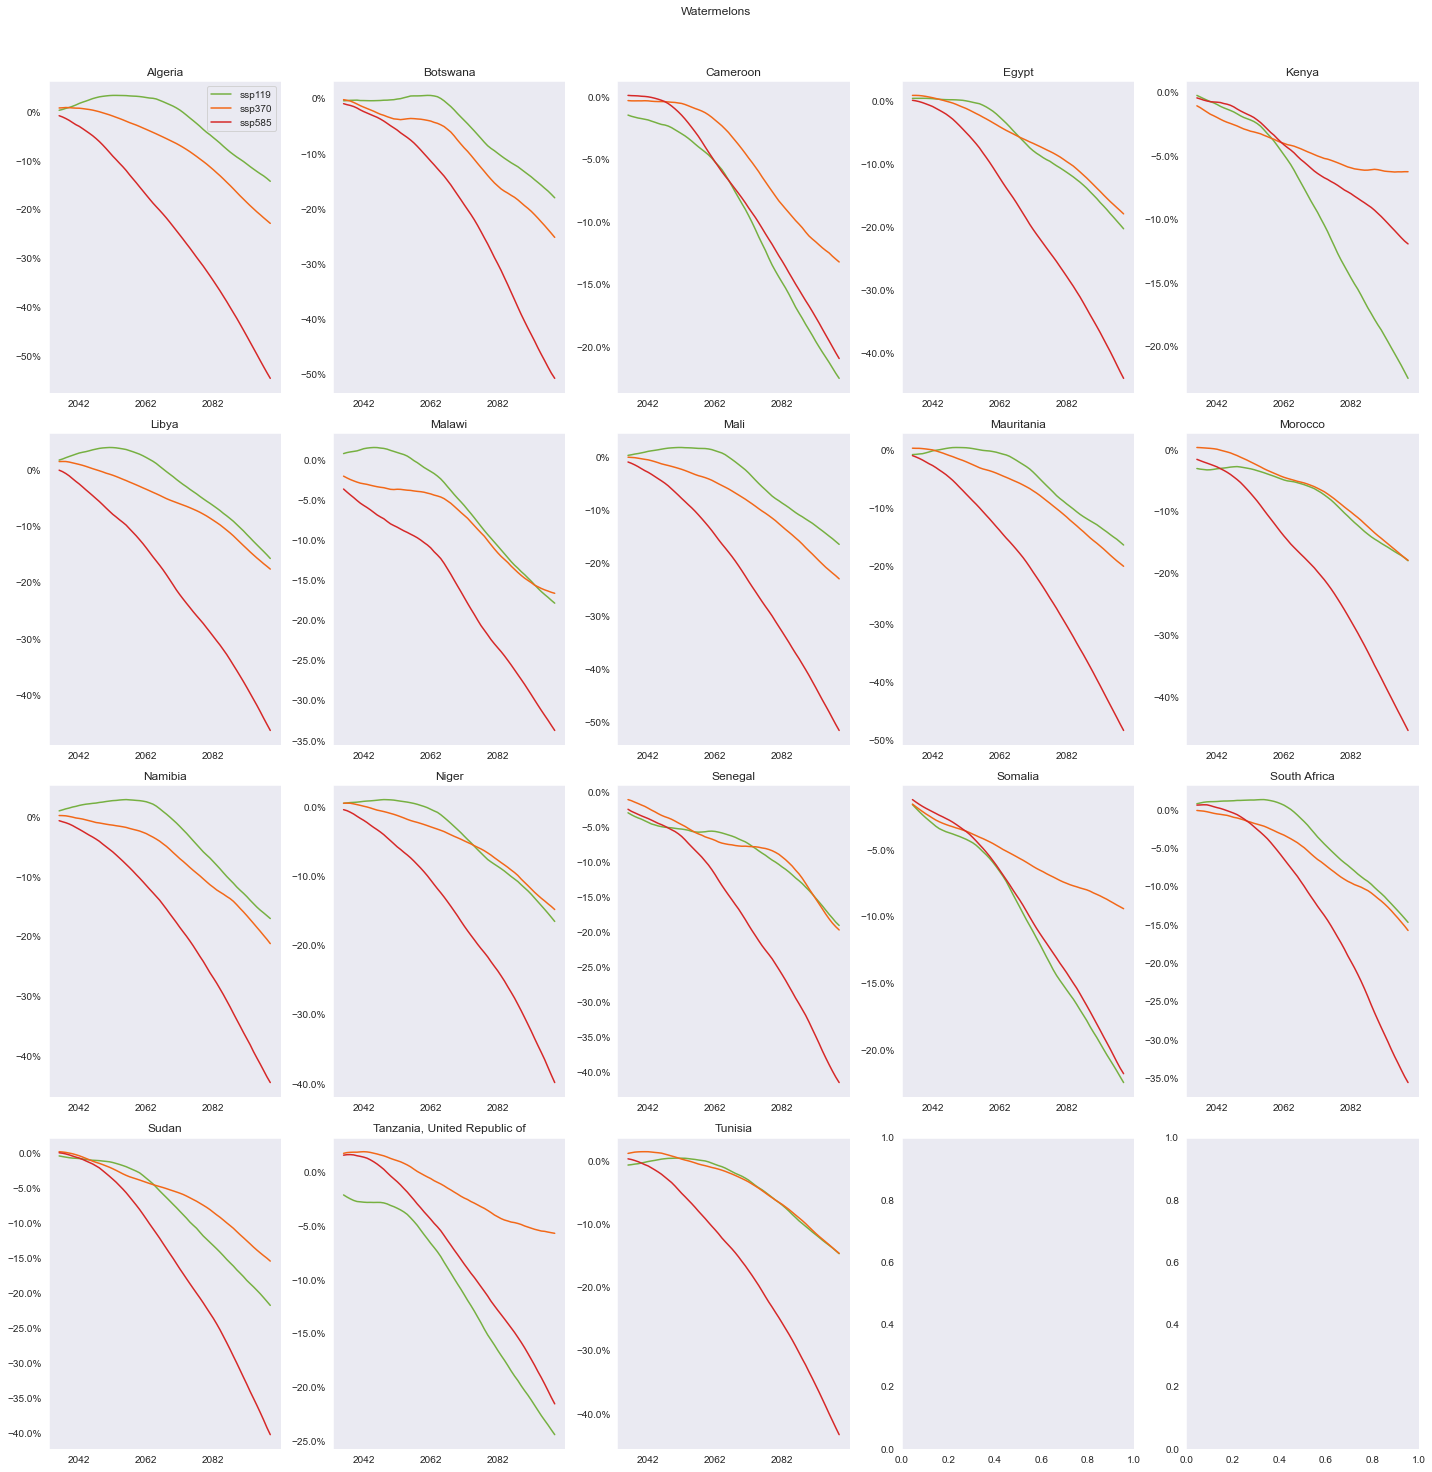

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
sns.set_style("dark")

import math 

pathways = ['ssp119', 'ssp370', 'ssp585']

colors = {
       'ssp585': '#D62828',
       'ssp370': '#F26818',
       'ssp119': '#76b041',
}

x = 5

crop = 'Watermelons'

crop_data = climate_damage_full_pct.xs(crop, axis=1, level=1)
crop_data = crop_data.rolling(15).mean()


x = 5

fig, ax = plt.subplots(math.ceil(len(crop_data.columns.get_level_values(0).unique()) / x ),x, figsize=(20,20))
axes = ax.flatten()

for i, country in enumerate(crop_data.columns.get_level_values(0).unique()):
       for j, pathway in enumerate(pathways):
              pct_series = crop_data.loc[:, (country, f'{pathway}')]
              
              axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
              pct_series.plot(ax=axes[i], label=f'{pathway}', color=colors[pathway])
              axes[i].set_title(f'{country}')


axes[0].legend()

fig.suptitle(f'{crop}', y=1.02)

plt.tight_layout()

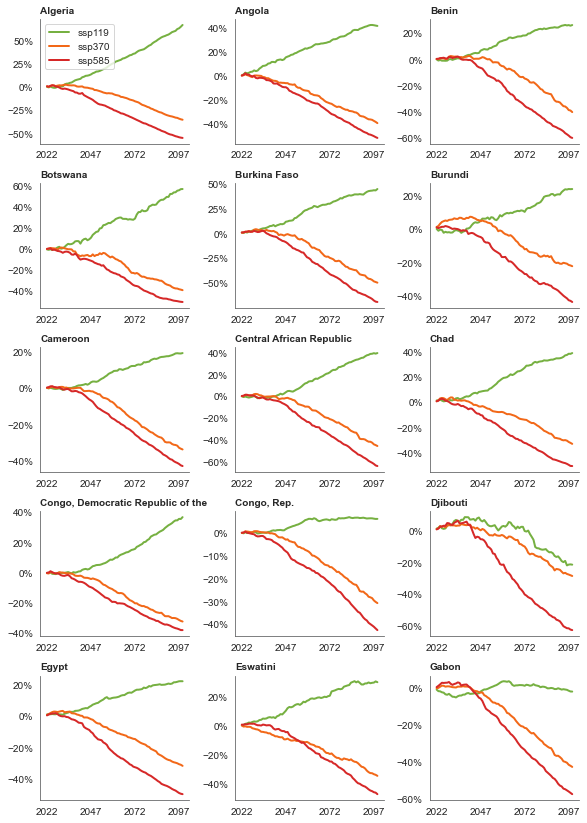

In [213]:
import seaborn as sns
sns.set_style("white")

major_crops = ['Wheat', 'Soybeans', 'Maize', 'Barley', 'Apples', 'Apricots', 'Beans, dry', 'Cabbages and other brassicas', 'Oats', 'Rice, paddy', 'Seed cotton', 'Tangerines, mandarins, clementines, satsumas', 'Tobacco, unmanufactured', 'Tomatoes', 'Watermelons']

major_df = climate_damage_full_pct.loc[:, climate_damage_full_pct.columns.get_level_values(1).isin(major_crops)]

major_df = major_df.groupby(level=[0,2], axis=1).mean()#.loc[:pd.Period('2050'),:]


pathways = ['ssp119',  'ssp370', 'ssp585']

colors = {
       'ssp585': '#D62828',
       'ssp370': '#F26818',
       'ssp119': '#76b041',
       'ssp245': '#000000',
}


x = 3

countries_1 = major_df.columns.get_level_values(0).unique()[:math.floor(len(major_df.columns.get_level_values(0).unique()) / 3)]


fig, ax = plt.subplots(math.ceil(len(countries_1) / x ), x, figsize=(8.26772, 11.6929))
axes = ax.flatten()

subtitle_design = {
       'fontsize': 10,
       'fontweight':  'bold',
       'verticalalignment': 'baseline',
       'horizontalalignment': 'left',
}

for i, country in enumerate(countries_1):
       for j, pathway in enumerate(pathways):
              pct_series = major_df.loc[:, (country, pathway)]
              
              axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
              pct_series.plot(ax=axes[i], label=f'{pathway}', color=colors[pathway], linewidth=2)

              axes[i].spines['top'].set_visible(False)
              axes[i].spines['right'].set_visible(False)

              # soft grey color
              axes[i].spines['bottom'].set_color('#616263')
              axes[i].spines['left'].set_color('#616263')


              axes[i].set_title(f'{country}', fontdict=subtitle_design , loc='left')

              
axes[0].legend()



fig.suptitle('', y=1.02)

plt.tight_layout()

plt.savefig('../output/mean_damage_by_pathway1.png', dpi=300)


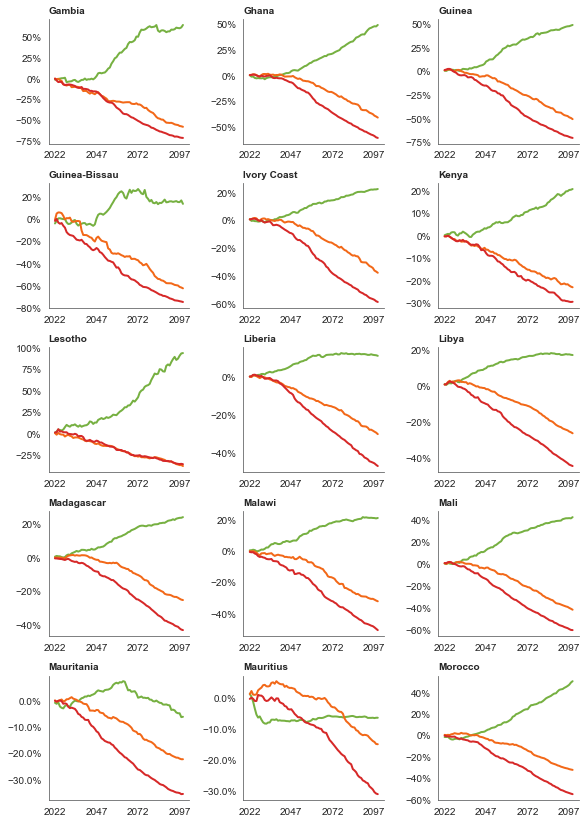

In [214]:
import seaborn as sns
sns.set_style("white")

major_crops = ['Wheat', 'Soybeans', 'Maize', 'Barley', 'Apples', 'Apricots', 'Beans, dry', 'Cabbages and other brassicas', 'Oats', 'Rice, paddy', 'Seed cotton', 'Tangerines, mandarins, clementines, satsumas', 'Tobacco, unmanufactured', 'Tomatoes', 'Watermelons']

major_df = climate_damage_full_pct.loc[:, climate_damage_full_pct.columns.get_level_values(1).isin(major_crops)]

major_df = major_df.groupby(level=[0,2], axis=1).mean()#.loc[:pd.Period('2050'),:]


pathways = ['ssp119',  'ssp370', 'ssp585']

colors = {
       'ssp585': '#D62828',
       'ssp370': '#F26818',
       'ssp119': '#76b041',
       'ssp245': '#000000',
}


x = 3

countries_1 = major_df.columns.get_level_values(0).unique()[math.floor(len(major_df.columns.get_level_values(0).unique()) / 3):math.floor(len(major_df.columns.get_level_values(0).unique()) / 3)+15]


fig, ax = plt.subplots(math.ceil(len(countries_1) / x ), x, figsize=(8.26772, 11.6929))
axes = ax.flatten()

subtitle_design = {
       'fontsize': 10,
       'fontweight':  'bold',
       'verticalalignment': 'baseline',
       'horizontalalignment': 'left',
}

for i, country in enumerate(countries_1):
       for j, pathway in enumerate(pathways):
              pct_series = major_df.loc[:, (country, pathway)]
              
              axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
              pct_series.plot(ax=axes[i], label=f'{pathway}', color=colors[pathway], linewidth=2)

              axes[i].spines['top'].set_visible(False)
              axes[i].spines['right'].set_visible(False)

              # soft grey color
              axes[i].spines['bottom'].set_color('#616263')
              axes[i].spines['left'].set_color('#616263')


              axes[i].set_title(f'{country}', fontdict=subtitle_design , loc='left')

              
# axes[0].legend()



fig.suptitle('', y=1.02)

plt.tight_layout()

plt.savefig('../output/mean_damage_by_pathway2.png', dpi=300)

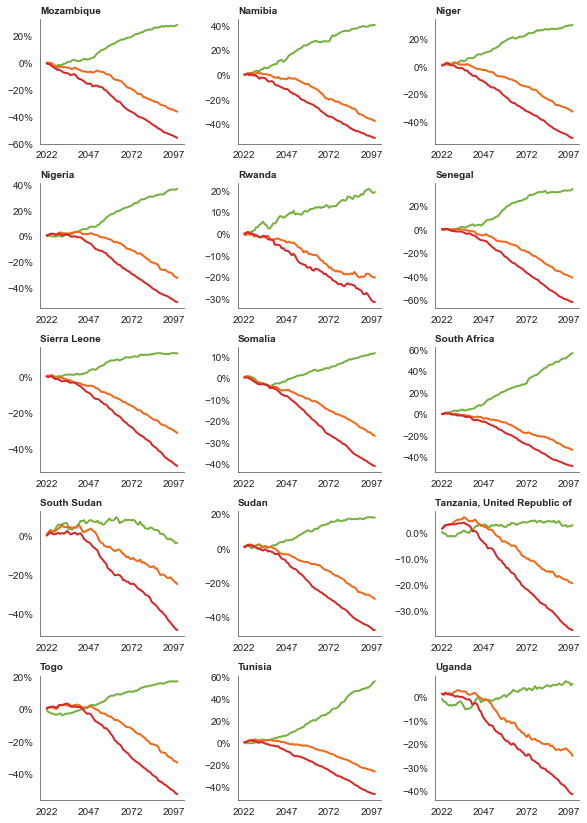

In [215]:
import seaborn as sns
sns.set_style("white")

major_crops = ['Wheat', 'Soybeans', 'Maize', 'Barley', 'Apples', 'Apricots', 'Beans, dry', 'Cabbages and other brassicas', 'Oats', 'Rice, paddy', 'Seed cotton', 'Tangerines, mandarins, clementines, satsumas', 'Tobacco, unmanufactured', 'Tomatoes', 'Watermelons']

major_df = climate_damage_full_pct.loc[:, climate_damage_full_pct.columns.get_level_values(1).isin(major_crops)]

major_df = major_df.groupby(level=[0,2], axis=1).mean()#.loc[:pd.Period('2050'),:]


pathways = ['ssp119',  'ssp370', 'ssp585']

colors = {
       'ssp585': '#D62828',
       'ssp370': '#F26818',
       'ssp119': '#76b041',
       'ssp245': '#000000',
}


x = 3

countries_1 = major_df.columns.get_level_values(0).unique()[math.floor(len(major_df.columns.get_level_values(0).unique()) / 3)+15:math.floor(len(major_df.columns.get_level_values(0).unique()) / 3)+30]


fig, ax = plt.subplots(math.ceil(len(countries_1) / x ), x, figsize=(8.26772, 11.6929))
axes = ax.flatten()

subtitle_design = {
       'fontsize': 10,
       'fontweight':  'bold',
       'verticalalignment': 'baseline',
       'horizontalalignment': 'left',
}

for i, country in enumerate(countries_1):
       for j, pathway in enumerate(pathways):
              pct_series = major_df.loc[:, (country, pathway)]
              
              axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
              pct_series.plot(ax=axes[i], label=f'{pathway}', color=colors[pathway], linewidth=2)

              axes[i].spines['top'].set_visible(False)
              axes[i].spines['right'].set_visible(False)

              # soft grey color
              axes[i].spines['bottom'].set_color('#616263')
              axes[i].spines['left'].set_color('#616263')


              axes[i].set_title(f'{country}', fontdict=subtitle_design , loc='left')

              
# axes[0].legend()



fig.suptitle('', y=1.02)

plt.tight_layout()

plt.savefig('../output/mean_damage_by_pathway3.png', dpi=300)

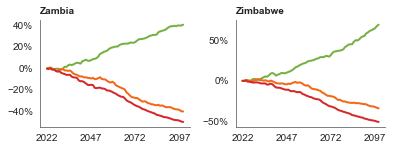

In [216]:
import seaborn as sns
sns.set_style("white")

major_crops = ['Wheat', 'Soybeans', 'Maize', 'Barley', 'Apples', 'Apricots', 'Beans, dry', 'Cabbages and other brassicas', 'Oats', 'Rice, paddy', 'Seed cotton', 'Tangerines, mandarins, clementines, satsumas', 'Tobacco, unmanufactured', 'Tomatoes', 'Watermelons']

major_df = climate_damage_full_pct.loc[:, climate_damage_full_pct.columns.get_level_values(1).isin(major_crops)]

major_df = major_df.groupby(level=[0,2], axis=1).mean()#.loc[:pd.Period('2050'),:]


pathways = ['ssp119',  'ssp370', 'ssp585']

colors = {
       'ssp585': '#D62828',
       'ssp370': '#F26818',
       'ssp119': '#76b041',
       'ssp245': '#000000',
}


x = 3

countries_1 = major_df.columns.get_level_values(0).unique()[math.floor(len(major_df.columns.get_level_values(0).unique()) / 3)+30:]


fig, ax = plt.subplots(math.ceil(len(countries_1) / x ), x, figsize=(8.26772, 11.6929 /5))
axes = ax.flatten()

subtitle_design = {
       'fontsize': 10,
       'fontweight':  'bold',
       'verticalalignment': 'baseline',
       'horizontalalignment': 'left',
}

for i, country in enumerate(countries_1):
       for j, pathway in enumerate(pathways):
              pct_series = major_df.loc[:, (country, pathway)]
              
              axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
              pct_series.plot(ax=axes[i], label=f'{pathway}', color=colors[pathway], linewidth=2)

              axes[i].spines['top'].set_visible(False)
              axes[i].spines['right'].set_visible(False)

              # soft grey color
              axes[i].spines['bottom'].set_color('#616263')
              axes[i].spines['left'].set_color('#616263')


              axes[i].set_title(f'{country}', fontdict=subtitle_design , loc='left')

              
              
# axes[0].legend()
axes[-1].remove()


fig.suptitle('', y=1.02)

plt.tight_layout()

plt.savefig('../output/mean_damage_by_pathway4.png', dpi=300)

In [222]:
major_df.columns.get_level_values(0).unique().to_series().to_clipboard()

In [240]:
regions = pd.read_excel(f'{base_path}/regions.xlsx')
region_conv = major_df.columns.get_level_values(0).to_series().apply(lambda x: regions.loc[regions['Country'] == x, 'Region'].values[0])

# Add back into multiindex
reg_df = major_df.copy()
reg_df.columns = pd.MultiIndex.from_tuples(zip(region_conv, major_df.columns.get_level_values(1)), names=['Region', 'Pathway'])
reg_df = reg_df.groupby(level=[0,1], axis=1).mean()

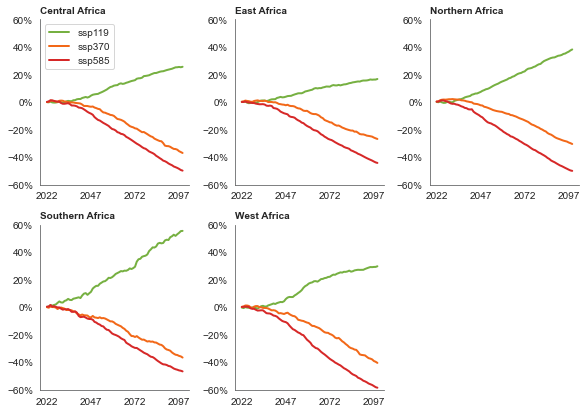

In [263]:
fig, ax = plt.subplots(2, 3, figsize=(8.26772, 11.6929 /2))

axes = ax.flatten()

for i, region in enumerate(reg_df.columns.get_level_values(0).unique()):
    reg_data = reg_df.loc[:, region]
    for pathway in pathways:
        pct_series = reg_data.loc[:, pathway]
        pct_series.plot(ax=axes[i], label=f'{pathway}', color=colors[pathway], linewidth=2)

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        # soft grey color
        axes[i].spines['bottom'].set_color('#616263')
        axes[i].spines['left'].set_color('#616263')

        # set ylim 
        axes[i].set_ylim(-.6, .6)
        
        axes[i].set_title(f'{region}', fontdict=subtitle_design , loc='left')

        axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

axes[-1].remove()

axes[0].legend()

plt.tight_layout()


plt.savefig('../output/mean_damage_by_pathway_region.png', dpi=300)
plt.show()



In [300]:
reg_df.index = pd.to_datetime(reg_df.index, format='%Y')

reg_df_10a = reg_df.resample('10A').mean()

pd.options.display.float_format = '{:.2%}'.format

# Drop ssp245 from the second level
reg_df_10a = reg_df_10a.drop(['ssp245'], level=1, axis=1)
reg_df_10a = reg_df_10a.T

reg_df_10a.columns = reg_df_10a.columns.to_period('10A')

reg_df_10a.to_latex('../output/mean_damage_by_pathway_region_10a.tex', float_format='{:.2%}'.format, position='H')
reg_df_10a

/var/folders/z7/kscqgjb16xs6t1mmw0gy5p4m0000gn/T/ipykernel_56655/1183648604.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  reg_df_10a.to_latex('../output/mean_damage_by_pathway_region_10a.tex', float_format='{:.2%}'.format, position='H')


2022   2032   2042    2052    2062    2072    2082  \
Region          Pathway                                                        
Central Africa  ssp119   0.01% -0.08%  1.49%   4.82%  10.13%  14.36%  18.65%   
                ssp370  -0.02%  0.68% -0.53%  -3.66%  -9.09% -15.77% -22.43%   
                ssp585   0.14%  0.20% -2.65%  -9.31% -17.94% -25.57% -33.71%   
East Africa     ssp119   0.14% -0.14%  1.60%   4.20%   7.38%  10.55%  12.47%   
                ssp370   0.33%  0.76%  0.26%  -2.24%  -6.13% -11.45% -17.59%   
                ssp585   0.07% -0.56% -2.93%  -8.90% -15.96% -23.66% -30.73%   
Northern Africa ssp119   0.10%  0.01%  3.08%   7.84%  13.81%  19.83%  25.91%   
                ssp370   0.48%  1.74%  0.98%  -2.61%  -6.84% -10.89% -16.98%   
                ssp585   0.30%  0.13% -3.70% -11.05% -19.26% -27.09% -34.68%   
Southern Africa ssp119   0.05%  2.52%  6.30%  12.63%  21.12%  27.11%  37.84%   
                ssp370  -0.01% -0.41% -3.60%  -6.92%  -9.92% -17.62% -23.71%   
                ssp585   0.39% -0.15% -3.95%  -9.57% -17.38% -25.80% -33.19%   
West Africa     ssp119  -0.29% -0.42%  1.56%   5.86%  14.12%  20.29%  24.67%   
                ssp370   0.21%  0.50% -1.47%  -5.05% -10.56% -16.63% -23.61%   
                ssp585   0.19% -0.90% -4.59% -12.09% -21.90% -32.92% -42.10%   

                           2092    2102  
Region          Pathway                  
Central Africa  ssp119   22.40%  25.13%  
                ssp370  -29.59% -34.97%  
                ssp585  -41.76% -47.88%  
East Africa     ssp119   14.78%  16.27%  
                ssp370  -22.08% -25.37%  
                ssp585  -37.10% -42.50%  
Northern Africa ssp119   32.00%  36.11%  
                ssp370  -24.08% -28.87%  
                ssp585  -42.49% -48.33%  
Southern Africa ssp119   47.01%  53.33%  
                ssp370  -28.40% -34.81%  
                ssp585  -40.58% -45.35%  
West Africa     ssp119   26.82%  29.04%  
                ssp370  -32.19% -38.23%  
                ssp585  -50.53% -56.61%